# Lab 2: Local feature description
This is a notebook, which could help you with testing third lab assignment.
It contains utility functions for visualization, some test input for the functions you needs to implement,
and the output of the reference solution for the same test input.

template functions for the assignment contain a short description of what the function is supposed to do,
and produce an incorrect output, which is nevertheless in proper format: type and shape.

You are not allowed to use kornia or opencv or any other library functions, which are specifically designed
to perform the operations requested in assignment

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import kornia
import cv2
import os
from PIL import Image
import kornia as K


def plot_torch(x, y, *kwargs):
    plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy(), *kwargs)
    return

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(kornia.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(kornia.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

def timg_load(fname, to_gray = True):
    img = cv2.imread(fname)
    with torch.no_grad():
        timg = kornia.image_to_tensor(img, False).float()
        if to_gray:
            timg = kornia.color.bgr_to_grayscale(timg)
        else:
            timg = kornia.color.bgr_to_rgb(timg)
    return timg


def visualize_detections(img, keypoint_locations, img_idx = 0, increase_scale = 1.):
    # Select keypoints relevant to image   
    kpts = [cv2.KeyPoint(b_ch_sc_y_x[4].item(),
                         b_ch_sc_y_x[3].item(),
                         increase_scale * b_ch_sc_y_x[2].item(), 90)
            for b_ch_sc_y_x in keypoint_locations if b_ch_sc_y_x[0].item() == img_idx]
    vis_img = None
    vis_img = cv2.drawKeypoints(kornia.tensor_to_image(img).astype(np.uint8),
                                kpts,
                                vis_img, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(12,10))
    plt.imshow(vis_img)
    return

First, we load an image to work with and detect some features

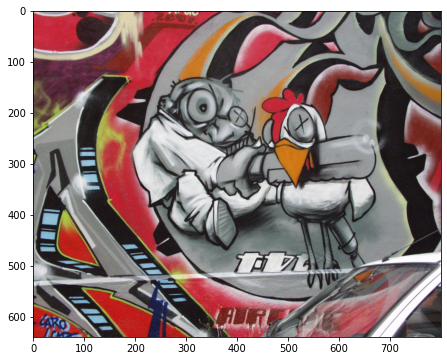

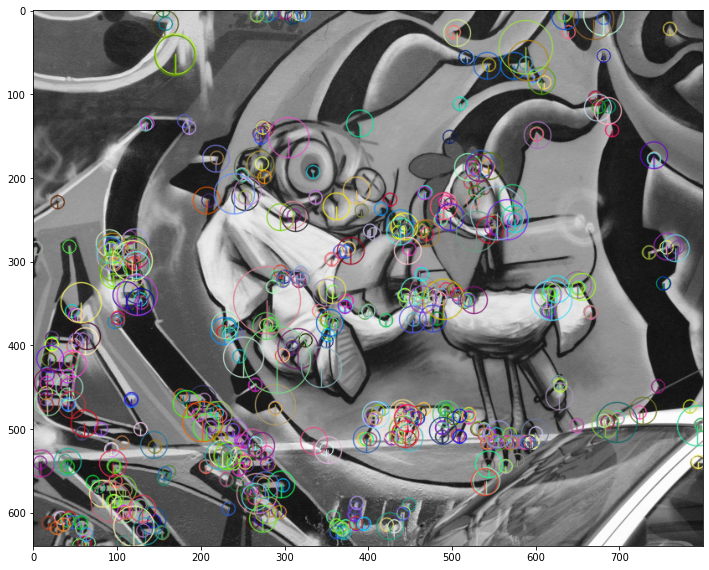

In [14]:
timg = timg_load('graffiti.ppm', False)/255.
timg_gray = kornia.color.rgb_to_grayscale(timg)
imshow_torch(timg)

from local_detector import *

with torch.no_grad():
    keypoint_locations = scalespace_harris(timg_gray, 0.00001)
    visualize_detections(timg_gray*255., keypoint_locations, increase_scale=16.0)

keypoint_locations=tensor([  0,   0,   1, 316, 122])
A=tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/torch/nn/functional.py:4241: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


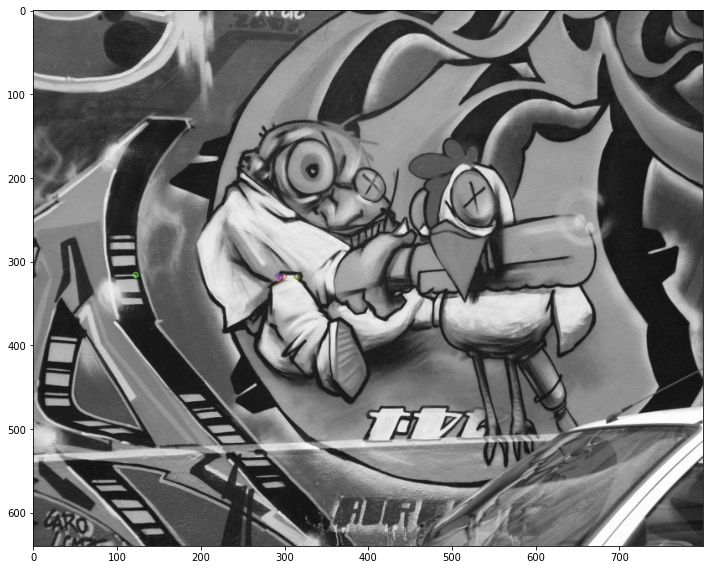

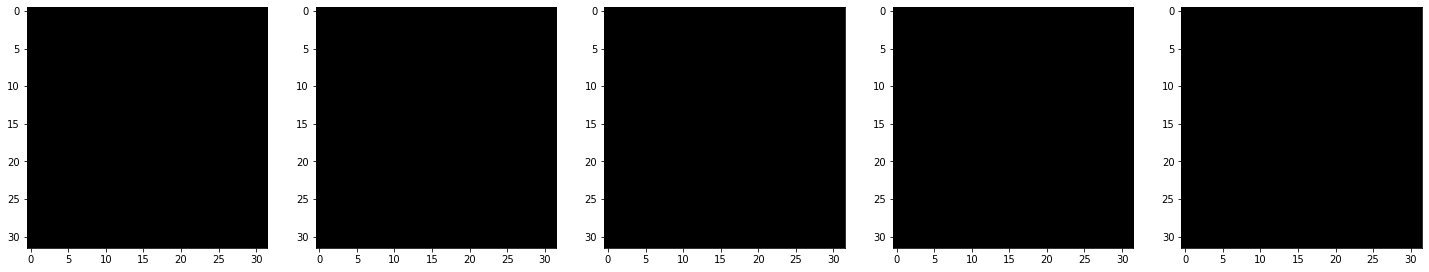

In [15]:
from local_descriptor import *

A, img_idxs = affine_from_location(keypoint_locations)

print (f'keypoint_locations={keypoint_locations[100]}')
print (f'A={A[100]}')

idxs = range(100,105)
visualize_detections(timg_gray*255., keypoint_locations[idxs], increase_scale=6.0) 
patches = extract_affine_patches(timg, A[idxs], img_idxs[idxs], 32, 6.0/2.)
# OpenCV visualization treats keypoint scale as diameter, while extract_affine_patches as radius,
# therefore we should divide by two to get same area

imshow_torch_channels(patches, 0)

## Reference example
```python
from local_descriptor import *

A, img_idxs = affine_from_location(keypoint_locations)

print (f'keypoint_locations={keypoint_locations[1000]}')
print (f'A={A[1000]}')

idxs = range(1000,1005)
visualize_detections(timg_gray*255., keypoint_locations[idxs], increase_scale=6.0) 
patches = extract_affine_patches(timg, A[idxs], img_idxs[idxs], 32, 6.0/2.)
# OpenCV visualization treats keypoint scale as diameter, while extract_affine_patches as radius,
# therefore we should divide by two to get same area

imshow_torch_channels(patches, 0)
```

![image.png](local_descriptor_files/att_00000.png)

In [16]:
from local_descriptor import *

input_kp_locations = torch.tensor([0, 0, 10., 150, 340]).view(1, 5)
input_orientation = torch.tensor([math.pi / 2.0]).view(1,1)
input_affine_shape = torch.tensor([4., 0., 2.]).view(1,3)

A, img_idxs  = affine_from_location(input_kp_locations)
print (A.long())
A1, img_idxs = affine_from_location_and_orientation(input_kp_locations, input_orientation)
print (A1.long())
A2, img_idxs = affine_from_location_and_orientation_and_affshape(input_kp_locations, 
                                                                 input_orientation,
                                                                 input_affine_shape)
print (A2.long())


tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])
tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])
tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])


## Refence example

```python
from local_descriptor import *

input_kp_locations = torch.tensor([0, 0, 10., 150, 340]).view(1, 5)
input_orientation = torch.tensor([math.pi / 2.0]).view(1,1)
input_affine_shape = torch.tensor([4., 0., 2.]).view(1,3)

A, img_idxs  = affine_from_location(input_kp_locations)
print (A.long())
A1, img_idxs = affine_from_location_and_orientation(input_kp_locations, input_orientation)
print (A1.long())
A2, img_idxs = affine_from_location_and_orientation_and_affshape(input_kp_locations, 
                                                                 input_orientation,
                                                                 input_affine_shape)
print (A2.long())
```
    tensor([[[ 10,   0, 340],
             [  0,  10, 150],
             [  0,   0,   1]]])
    tensor([[[  0,  10, 340],
             [-10,   0, 150],
             [  0,   0,   1]]])
    tensor([[[  0,   8, 340],
             [-11,   0, 150],
             [  0,   0,   1]]])

# Local patch orientation

Script for benchmarking local patch orientation, similar to one in AE

In [17]:
from local_descriptor import estimate_patch_dominant_orientation 
def normalize_angle(ang):
    #https://stackoverflow.com/a/22949941/1983544
    return ang - (torch.floor((ang + K.pi)/(2.0*K.pi)))*2.0*K.pi;

def benchmark_orientation_consistency(orienter, patches, PS_out, angles=[15], bins=36):
    import kornia as K
    from kornia.geometry.transform import center_crop, rotate
    from kornia.geometry.conversions import rad2deg, deg2rad
    errors = []
    with torch.no_grad():
        patches_orig_crop = center_crop(patches, (PS_out, PS_out))
        ang_out = normalize_angle(orienter(patches_orig_crop, bins))     
        for ang_gt in angles:
            ang_gt = torch.tensor(ang_gt)
            patches_ang = rotate(patches, ang_gt)
            patches_ang_crop = center_crop(patches_ang, (PS_out, PS_out))
            ang_out_ang = normalize_angle(orienter(patches_ang_crop, bins))
            error_aug_cw = normalize_angle(ang_out - deg2rad(ang_gt) - ang_out_ang).abs()
            error_aug_ccw = normalize_angle(ang_out + deg2rad(ang_gt) - ang_out_ang).abs()
            if error_aug_ccw.mean().item() < error_aug_cw.mean().item():
                error_aug = error_aug_ccw
            else:
                error_aug = error_aug_cw
            errors.append(error_aug.mean())
            print (f'mean consistency error = {rad2deg(error_aug.mean()):.1f} [deg]') 
    return rad2deg(torch.stack(errors).mean())

Now lets load patches and check. Threshold for passing the test is 20 degrees

In [6]:
dir_fname = 'patches/'
fnames = os.listdir(dir_fname)
angles = [90., 60., 45., 30.]
PS_out = 32
PS = 65


angles = [70., 30.]
orienter = estimate_patch_dominant_orientation
with torch.no_grad():
    errors = []
    for f in fnames[::-1]:
        fname = os.path.join(dir_fname, f)
        patches = K.image_to_tensor(np.array(Image.open(fname).convert("L"))).float() / 255.
        patches = patches.reshape(-1, 1, PS, PS)
        err = benchmark_orientation_consistency(orienter, patches, PS_out, angles)
        errors.append(err)
    AVG_ERR = torch.stack(errors).mean().item()
    print (f'Average error = {AVG_ERR:.1f} deg')


mean consistency error = 1.9 [deg]
mean consistency error = 3.0 [deg]
Average error = 2.4 deg


## Refence example

```python
dir_fname = 'patches/'
fnames = os.listdir(dir_fname)
angles = [90., 60., 45., 30.]
PS_out = 32
PS = 65
import sys
sys.path.insert(0,'/home/old-ufo/dev/BRUTE/mpv-test-04/upload_system/')
from refence_solution.local_descriptor import estimate_patch_dominant_orientation as REF


angles = [70., 30.]
orienter = REF
with torch.no_grad():
    errors = []
    for f in fnames[::-1]:
        fname = os.path.join(dir_fname, f)
        patches = K.image_to_tensor(np.array(Image.open(fname).convert("L"))).float() / 255.
        patches = patches.reshape(-1, 1, PS, PS)
        err = benchmark_orientation_consistency(orienter, patches, PS_out, angles)
        errors.append(err)
    AVG_ERR = torch.stack(errors).mean().item()
    print (f'Average error = {AVG_ERR:.1f} deg')
```

    mean consistency error = 1.9 [deg]
    mean consistency error = 3.0 [deg]
    Average error = 2.4 deg